In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

import warnings
warnings.filterwarnings('ignore')

C:\Users\Yoann\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
sns.set_theme(rc={'figure.figsize':(12,8)})

In [3]:
pd.set_option('use_inf_as_na', True)

# Préparation données

In [4]:
iris = gpd.read_file("iris/CONTOURS-IRIS_3-0__SHP__FRA_2023-01-01/CONTOURS-IRIS_3-0__SHP__FRA_2023-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2024-02-00238/CONTOURS-IRIS_3-0_SHP_LAMB93_FXX-ED2023-01-01/CONTOURS-IRIS.shp")
iris=iris[["CODE_IRIS", "NOM_IRIS", "TYP_IRIS", "geometry"]]
iris=iris.rename(columns={"CODE_IRIS" : "IRIS"})
iris = iris.to_crs(4326)
iris["IRIS"]=iris["IRIS"].astype(str)
iris=iris[iris["IRIS"]<"970000000"]
iris=iris[~iris["IRIS"].str.startswith("57")]
iris=iris[~iris["IRIS"].str.startswith("58")]
iris=iris[~iris["IRIS"].str.startswith("68")]

In [5]:
df_activite=pd.read_csv("iris/activite_iris_2021.csv", sep=",", decimal=",")
df_activite=df_activite.drop(columns=["LIBCOM", "LIBIRIS", "TYP_IRIS"])
df_activite["COM"]=df_activite["COM"].astype(str)
df_activite["IRIS"]=df_activite["IRIS"].astype(str)

In [6]:
df_log=pd.read_csv("iris/log_iris_2021.csv", sep=",", decimal=",")
df_log=df_log.drop(columns=["COM", "LIBCOM", "LIBIRIS", "TYP_IRIS"])
df_log["IRIS"]=df_log["IRIS"].astype(str)

In [7]:
df_commerce = pd.read_csv("iris/commerce.csv", sep=",", decimal=",")
df_edu = pd.read_csv("iris/education.csv", sep=",", decimal=",")
df_sante = pd.read_csv("iris/sante.csv", sep=",", decimal=",")
df_sport_culture = pd.read_csv("iris/sport_culture.csv", sep=",", decimal=",")


df_commerce["COD_INSEE"]=df_commerce["COD_INSEE"].astype(str)
df_edu["COD_INSEE"]=df_edu["COD_INSEE"].astype(str)
df_sante["COD_INSEE"]=df_sante["COD_INSEE"].astype(str)
df_sport_culture["COD_INSEE"]=df_sport_culture["COD_INSEE"].astype(str)

In [8]:
df_info_iris=df_activite.merge(df_log, how="left", on="IRIS")
df_info_iris=df_info_iris[df_info_iris["IRIS"]<"970000000"]
df_info_iris=df_info_iris[~df_info_iris["IRIS"].str.startswith("57")]
df_info_iris=df_info_iris[~df_info_iris["IRIS"].str.startswith("58")]
df_info_iris=df_info_iris[~df_info_iris["IRIS"].str.startswith("68")]

In [9]:
#y a t il une activité économique dans la zone
df_info_iris["TX_ACTOCC1564"]=df_info_iris["C21_ACTOCC1564"]/df_info_iris["C21_ACT1564"]

#détail des activités économiques
df_info_iris["TX_ACTOCC1564_CS1"]=df_info_iris["C21_ACTOCC1564_CS1"]/df_info_iris["C21_ACTOCC1564"]
df_info_iris["TX_ACTOCC1564_CS2"]=df_info_iris["C21_ACTOCC1564_CS2"]/df_info_iris["C21_ACTOCC1564"]
df_info_iris["TX_ACTOCC1564_CS3"]=df_info_iris["C21_ACTOCC1564_CS3"]/df_info_iris["C21_ACTOCC1564"]
df_info_iris["TX_ACTOCC1564_CS4"]=df_info_iris["C21_ACTOCC1564_CS4"]/df_info_iris["C21_ACTOCC1564"]
df_info_iris["TX_ACTOCC1564_CS5"]=df_info_iris["C21_ACTOCC1564_CS5"]/df_info_iris["C21_ACTOCC1564"]
df_info_iris["TX_ACTOCC1564_CS6"]=df_info_iris["C21_ACTOCC1564_CS6"]/df_info_iris["C21_ACTOCC1564"]

#est ce que la zone est essentiellement touristique
df_info_iris["TX_RSECOCC"]=df_info_iris["P21_RSECOCC"]/df_info_iris["P21_LOG"]

#est ce que le parc est viellissant
df_info_iris["TX_RPAPPART_ACH19"]=df_info_iris["P21_RPAPPART_ACH19"]/df_info_iris["P21_RPAPPART"]
df_info_iris["TX_RPAPPART_ACH45"]=df_info_iris["P21_RPAPPART_ACH45"]/df_info_iris["P21_RPAPPART"]
df_info_iris["TX_RPAPPART_ACH70"]=df_info_iris["P21_RPAPPART_ACH70"]/df_info_iris["P21_RPAPPART"]
df_info_iris["TX_RPAPPART_ACH90"]=df_info_iris["P21_RPAPPART_ACH90"]/df_info_iris["P21_RPAPPART"]
df_info_iris["TX_RPAPPART_ACH05"]=df_info_iris["P21_RPAPPART_ACH05"]/df_info_iris["P21_RPAPPART"]
df_info_iris["TX_RPAPPART_ACH18"]=df_info_iris["P21_RPAPPART_ACH18"]/df_info_iris["P21_RPAPPART"]

#la zone est elle majoritairement propriétaire
df_info_iris["TX_RP_PROP"]=df_info_iris["P21_RP_PROP"]/df_info_iris["P21_RPAPPART"]



In [10]:
df_info_iris=df_info_iris[["IRIS", "COM", 'TX_ACTOCC1564', 'TX_ACTOCC1564_CS1', 'TX_ACTOCC1564_CS2',
       'TX_ACTOCC1564_CS3', 'TX_ACTOCC1564_CS4', 'TX_ACTOCC1564_CS5',
       'TX_ACTOCC1564_CS6', 'TX_RSECOCC', 'TX_RPAPPART_ACH19',
       'TX_RPAPPART_ACH45', 'TX_RPAPPART_ACH70', 'TX_RPAPPART_ACH90',
       'TX_RPAPPART_ACH05', 'TX_RPAPPART_ACH18', 'TX_RP_PROP']]

In [11]:
df_info_iris=df_info_iris.merge(df_commerce.drop(columns="LIB_INSEE").rename(columns={"COD_INSEE" : "COM"}), how="left", on="COM")
df_info_iris=df_info_iris.merge(df_sante.drop(columns="LIB_INSEE").rename(columns={"COD_INSEE" : "COM"}), how="left", on="COM")
df_info_iris=df_info_iris.merge(df_edu.drop(columns="LIB_INSEE").rename(columns={"COD_INSEE" : "COM"}), how="left", on="COM")
df_info_iris=df_info_iris.merge(df_sport_culture.drop(columns="LIB_INSEE").rename(columns={"COD_INSEE" : "COM"}), how="left", on="COM")

In [12]:
df_info_iris=df_info_iris.fillna(0)

In [13]:
df_info_iris=df_info_iris.drop(columns="COM")

In [14]:
df_info_iris=iris.merge(df_info_iris, how="left", on="IRIS")

In [15]:
df_info_iris

,IRIS,NOM_IRIS,TYP_IRIS,geometry,TX_ACTOCC1564,TX_ACTOCC1564_CS1,TX_ACTOCC1564_CS2,TX_ACTOCC1564_CS3,TX_ACTOCC1564_CS4,TX_ACTOCC1564_CS5,...,TX_RPAPPART_ACH18,TX_RP_PROP,ALI_23,AUTRE_COM_23,SANTE_23,ECOLE_23,SUP_23,RES_ETU_23,SPORT_23,CULTURE_23
0,012400000,Matafelon-Granges,Z,"POLYGON ((5.53188 46.23429, 5.53168 46.23533, ...",0.930588,0.000000,0.080188,0.090395,0.275315,0.244259,...,0.044064,12.254317,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0
1,012660000,Montrevel-en-Bresse,Z,"POLYGON ((5.10765 46.34753, 5.11022 46.34678, ...",0.880748,0.005657,0.057905,0.063152,0.283928,0.307236,...,0.312711,1.602987,6.0,15.0,48.0,3.0,0.0,0.0,12.0,1.0
2,012130000,Leyment,Z,"POLYGON ((5.29228 45.94866, 5.29433 45.94847, ...",0.930825,0.016027,0.068328,0.143498,0.314289,0.157727,...,0.450056,18.762648,1.0,4.0,4.0,2.0,0.0,0.0,7.0,0.0
3,013970000,Sauverny,Z,"POLYGON ((6.10388 46.30690, 6.10149 46.30855, ...",0.903418,0.000000,0.031748,0.294862,0.262261,0.285256,...,0.000000,2.291286,0.0,1.0,0.0,1.0,0.0,0.0,3.0,1.0
4,010610000,Brens,Z,"POLYGON ((5.68601 45.73385, 5.68720 45.73428, ...",0.928193,0.000000,0.097835,0.176909,0.303368,0.215863,...,0.506922,70.375651,1.0,1.0,0.0,1.0,0.0,0.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46811,955850111,Pasteur,H,"POLYGON ((2.38268 48.97515, 2.38291 48.97581, ...",0.829316,0.000000,0.029911,0.047451,0.183553,0.356558,...,0.012431,0.097792,122.0,168.0,443.0,64.0,8.0,0.0,43.0,5.0
46812,954280304,Haut Montmorency Sud,H,"POLYGON ((2.32471 48.99316, 2.32158 48.99342, ...",0.853759,0.000000,0.102932,0.299932,0.243282,0.229368,...,0.102003,1.344132,39.0,45.0,160.0,10.0,1.0,0.0,27.0,5.0
46813,956040000,Survilliers,Z,"POLYGON ((2.54207 49.12225, 2.54216 49.12222, ...",0.921239,0.000000,0.031713,0.110181,0.328782,0.329422,...,0.143084,0.984688,6.0,4.0,19.0,4.0,0.0,0.0,9.0,1.0
46814,954760103,L'Oseraie,A,"POLYGON ((2.07645 49.07548, 2.07636 49.07556, ...",0.909586,0.000000,0.096472,0.164837,0.336501,0.312487,...,0.000000,20.300513,37.0,81.0,196.0,20.0,2.0,0.0,43.0,1.0


In [16]:
df=pd.read_parquet("iris/dvf-2021.parquet")

In [17]:
df["code_commune"]=df["code_commune"].astype(str)

#on ne garde que la metropole
df=df[df["code_commune"]<"97000"]

#on ne s'interesse qu'aux ventes de bien unique
df=df[df["nature_mutation"]=="Vente"]
df=df.drop_duplicates(subset="id_mutation", keep=False)

#on se focalise sur les appartements sans terrains
df=df[df["type_local"]=="Appartement"]
df=df[df["surface_terrain"].isna()]


#On ne garde que les biens "classiques" 
df=df[df["nombre_pieces_principales"]<=3]
df=df[df["nombre_pieces_principales"]>=1]

#on supprime les biens trop petits
df=df[df["surface_reelle_bati"]>=10]

#on ne conserve que les infos pertinentes
df["prx_m2"]=df["valeur_fonciere"]/df["surface_reelle_bati"]
df=df[["id_mutation", "code_commune", "nom_commune", "surface_reelle_bati",
       "nombre_pieces_principales", 'longitude', 'latitude', "prx_m2", "valeur_fonciere"]]

#on supprime les ventes où une information est manquante
df=df.dropna()

#on supprime les ventes symboliques
df=df[df["valeur_fonciere"]>1]

#on effectue un nouveau filtrage plus précis sur les biens et ventes classiques 
index_ok=set()
for i in range(1,4,1):
    
    #on supprime les biens trop petits ou trop grand par nombre de pieces
    subset=df[(df["nombre_pieces_principales"]==i)]
    fitted_data, fitted_lambda = stats.boxcox(subset["surface_reelle_bati"])
    fitted_data_norm=(fitted_data-np.mean(fitted_data))/np.std(fitted_data)
    subset=subset[(fitted_data_norm<3) & (fitted_data_norm>-3)]
    
    #on supprime les biens trop "cheap" ou trop chere par nombre de pieces
    fitted_data, fitted_lambda = stats.boxcox(subset["prx_m2"])
    fitted_data_norm=(fitted_data-np.mean(fitted_data))/np.std(fitted_data)
    subset=subset[(fitted_data_norm<3) & (fitted_data_norm>-3)]
    
    
    index_ok.update(subset.index)
df=df.loc[list(index_ok)]

df=df.drop(columns=["valeur_fonciere"])

In [18]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

In [19]:
gdf=gdf.sjoin(df_info_iris, how="left", predicate="within")
gdf=gdf.drop(columns=["index_right"])

In [20]:
gdf=gdf.dropna()

In [21]:
gdf=gdf.reset_index(drop=True)

In [22]:
gdf

,id_mutation,code_commune,nom_commune,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,prx_m2,geometry,IRIS,...,TX_RPAPPART_ACH18,TX_RP_PROP,ALI_23,AUTRE_COM_23,SANTE_23,ECOLE_23,SUP_23,RES_ETU_23,SPORT_23,CULTURE_23
0,2021-659313,38185,Grenoble,18.0,1.0,5.726562,45.164403,2500.000000,POINT (5.72656 45.16440),381850608,...,0.285472,0.370687,480.0,848.0,2035.0,102.0,52.0,12.0,228.0,37.0
1,2021-278866,19031,Brive-la-Gaillarde,32.0,2.0,1.536490,45.165959,3489.375000,POINT (1.53649 45.16596),190310701,...,0.061600,0.894639,158.0,373.0,571.0,50.0,21.0,1.0,97.0,9.0
2,2021-1135238,69029,Bron,52.0,3.0,4.919262,45.740936,1980.769231,POINT (4.91926 45.74094),690290201,...,0.065750,0.662735,71.0,88.0,347.0,23.0,12.0,0.0,64.0,8.0
3,2021-278869,19031,Brive-la-Gaillarde,52.0,2.0,1.535529,45.158873,1730.769231,POINT (1.53553 45.15887),190310101,...,0.014008,0.236261,158.0,373.0,571.0,50.0,21.0,1.0,97.0,9.0
4,2021-554226,34344,La Grande-Motte,25.0,1.0,4.082632,43.560735,2760.000000,POINT (4.08263 43.56074),343440101,...,0.002867,0.517566,63.0,94.0,162.0,5.0,0.0,0.0,35.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89590,2021-554198,34172,Montpellier,18.0,1.0,3.873771,43.610107,4277.777778,POINT (3.87377 43.61011),341722503,...,0.009338,0.208717,792.0,1065.0,3832.0,199.0,151.0,28.0,349.0,39.0
89591,2021-1135220,69259,Vénissieux,24.0,2.0,4.886101,45.706136,3020.833333,POINT (4.88610 45.70614),692590803,...,0.189200,0.259627,84.0,103.0,529.0,53.0,8.0,0.0,70.0,8.0
89592,2021-1135221,69266,Villeurbanne,54.0,3.0,4.883356,45.770090,2777.777778,POINT (4.88336 45.77009),692661001,...,0.031681,0.468773,296.0,350.0,1405.0,92.0,40.0,9.0,166.0,13.0
89593,2021-554210,34172,Montpellier,20.0,1.0,3.894940,43.610898,3572.500000,POINT (3.89494 43.61090),341722703,...,0.083403,0.440090,792.0,1065.0,3832.0,199.0,151.0,28.0,349.0,39.0


# approche locale (comparative)

In [23]:
# list_var=['TX_ACTOCC1564', 'TX_ACTOCC1564_CS1', 'TX_ACTOCC1564_CS2',
#        'TX_ACTOCC1564_CS3', 'TX_ACTOCC1564_CS4','TX_ACTOCC1564_CS5',
#        'TX_ACTOCC1564_CS6',
#         "ALI_23", "AUTRE_COM_23", "SANTE_23", "ECOLE_23", "SUP_23", "SPORT_23", "CULTURE_23",
#        'TX_RPAPPART_ACH19', 'TX_RPAPPART_ACH45', 'TX_RPAPPART_ACH70', 'TX_RPAPPART_ACH90',
#        'TX_RPAPPART_ACH05', 'TX_RPAPPART_ACH18',
#         'TX_RP_PROP', 'TX_RSECOCC',"RES_ETU_23"]


dico_hierarchie_var = {"activite" : 
                          {"general" : ['TX_ACTOCC1564'], 
                           "detail" : ['TX_ACTOCC1564_CS1', 'TX_ACTOCC1564_CS2',
                                       'TX_ACTOCC1564_CS3', 'TX_ACTOCC1564_CS4',
                                       'TX_ACTOCC1564_CS5','TX_ACTOCC1564_CS6']
                          }, 
                       "equipement" : 
                           {"commerce" : ["ALI_23", "AUTRE_COM_23"], 
                            "sante" : ["SANTE_23"],
                            "education" : ["ECOLE_23", "SUP_23"],
                            "sport_culture" : ["SPORT_23", "CULTURE_23"]
                           },
                       "age_parc" : ['TX_RPAPPART_ACH19', 'TX_RPAPPART_ACH45',
                                     'TX_RPAPPART_ACH70', 'TX_RPAPPART_ACH90',
                                     'TX_RPAPPART_ACH05', 'TX_RPAPPART_ACH18'],
                       "occupant" : ['TX_RP_PROP', 'TX_RSECOCC',"RES_ETU_23"],
                       "description" : ["surface_reelle_bati"]
                      }

p_dist=2


In [24]:
#Processus analytique hiérarchique

def PAH(l):
    n=len(l)
    w=np.ones((n,n))
    for i in range(0,n-1,1):
        for j in range(i+1, n, 1):
            a=input("importance de "+l[i].upper()+" par rapport à "+l[j].upper()+" : ")
            w[i][j]=float(a)
            w[j][i]=1/float(a)
        
    val, vec = np.linalg.eig(w)
    filtre_real=val.real==val
    val=val[filtre_real].real
    vec=vec.T
    vec=vec[filtre_real,:]
    v=np.argmax(val)
    return np.abs(vec[v])/np.sum(np.abs(vec[v]))

def travel(d, b=1, w=dict()):
    if type(d)==dict:
        list_k=list(d.keys())
        n=len(list_k)
        vec=b*PAH(list_k)
        for i in range(0, n ,1):
            travel(d[list_k[i]], b=vec[i], w=w)
    else : 
        n=len(d)
        if n==1:
            vec=[b]
        else : 
            vec=b*PAH(d)
        w.update(zip(d, vec))
    return w 
    

In [26]:
# poids=np.array([0.1, (1/6)*0.1, (1/6)*0.1, (1/6)*0.1, (1/6)*0.1, (1/6)*0.1, (1/6)*0.1, 
#                0.025, 0.025, 0.05, 0.025, 0.025, 0.025, 0.025, 
#                (1/6)*0.2, (1/6)*0.2, (1/6)*0.2, (1/6)*0.2, (1/6)*0.2, (1/6)*0.2, 
#                0.2*(1/3), 0.2*(1/3), 0.2*(1/3), 
#                0.2])**(1/p_dist)

dict_poids=travel(dico_hierarchie_var)

poids=np.array(list(dict_poids.values()))**(1/p_dist)

list_var=list(dict_poids.keys())

importance de ACTIVITE par rapport à EQUIPEMENT : 1
importance de ACTIVITE par rapport à AGE_PARC : 1
importance de ACTIVITE par rapport à OCCUPANT : 1
importance de ACTIVITE par rapport à DESCRIPTION : 1
importance de EQUIPEMENT par rapport à AGE_PARC : 1
importance de EQUIPEMENT par rapport à OCCUPANT : 1
importance de EQUIPEMENT par rapport à DESCRIPTION : 1
importance de AGE_PARC par rapport à OCCUPANT : 1
importance de AGE_PARC par rapport à DESCRIPTION : 1
importance de OCCUPANT par rapport à DESCRIPTION : 1
importance de GENERAL par rapport à DETAIL : 1
importance de TX_ACTOCC1564_CS1 par rapport à TX_ACTOCC1564_CS2 : 1
importance de TX_ACTOCC1564_CS1 par rapport à TX_ACTOCC1564_CS3 : 1
importance de TX_ACTOCC1564_CS1 par rapport à TX_ACTOCC1564_CS4 : 1
importance de TX_ACTOCC1564_CS1 par rapport à TX_ACTOCC1564_CS5 : 1
importance de TX_ACTOCC1564_CS1 par rapport à TX_ACTOCC1564_CS6 : 1
importance de TX_ACTOCC1564_CS2 par rapport à TX_ACTOCC1564_CS3 : 1
importance de TX_ACTOCC15

In [27]:
X_t1=gdf[gdf["nombre_pieces_principales"]==1][list_var].values
X_t2=gdf[gdf["nombre_pieces_principales"]==2][list_var].values
X_t3=gdf[gdf["nombre_pieces_principales"]==3][list_var].values


scaler_t1=RobustScaler(with_centering = False, quantile_range = (0.25, 0.75)).fit(X_t1)
scaler_t2=RobustScaler(with_centering = False, quantile_range = (0.25, 0.75)).fit(X_t2)
scaler_t3=RobustScaler(with_centering = False, quantile_range = (0.25, 0.75)).fit(X_t3)

In [28]:
X_t1=poids*scaler_t1.transform(X_t1)
X_t2=poids*scaler_t1.transform(X_t2)
X_t3=poids*scaler_t1.transform(X_t3)


Y_t1=gdf[gdf["nombre_pieces_principales"]==1][["prx_m2"]].values
Y_t2=gdf[gdf["nombre_pieces_principales"]==2][["prx_m2"]].values
Y_t3=gdf[gdf["nombre_pieces_principales"]==3][["prx_m2"]].values

In [29]:
def poids_exp(a):
    return np.exp(-a)/np.sum(np.exp(-a))


In [30]:
k1 = int(np.ceil(np.log(X_t1.shape[0])))
k2 = int(np.ceil(np.log(X_t2.shape[0])))
k3 = int(np.ceil(np.log(X_t3.shape[0])))

In [31]:
knn_t1=KNeighborsRegressor(n_neighbors=k1, weights=poids_exp, metric="minkowski", p=p_dist)
knn_t2=KNeighborsRegressor(n_neighbors=k2, weights=poids_exp, metric="minkowski", p=p_dist)
knn_t3=KNeighborsRegressor(n_neighbors=k3, weights=poids_exp, metric="minkowski", p=p_dist)


In [32]:
knn_t1.fit(X_t1,Y_t1)
knn_t2.fit(X_t2,Y_t2)
knn_t3.fit(X_t3,Y_t3)

KNeighborsRegressor(n_neighbors=11,
                    weights=<function poids_exp at 0x000001E4C7F70C10>)

In [33]:
df_info_iris["surface_reelle_bati"]=30
X_pred_t1=poids*scaler_t1.transform(df_info_iris[list_var].values)

df_info_iris["surface_reelle_bati"]=45
X_pred_t2=poids*scaler_t2.transform(df_info_iris[list_var].values)

df_info_iris["surface_reelle_bati"]=65
X_pred_t3=poids*scaler_t3.transform(df_info_iris[list_var].values)

df_info_iris=df_info_iris.drop(columns=["surface_reelle_bati"])

In [38]:
df_info_iris["pred_t1_30_comp"]=knn_t1.predict(X_pred_t1)
df_info_iris["pred_t2_45_comp"]=knn_t2.predict(X_pred_t2)
df_info_iris["pred_t3_65_comp"]=knn_t3.predict(X_pred_t3)

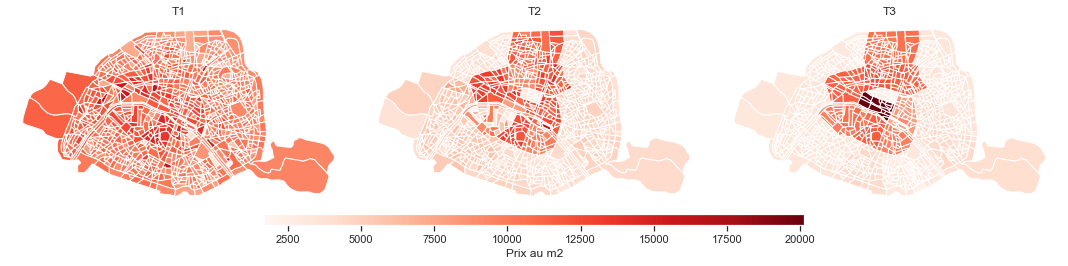

In [39]:
fig, axes = plt.subplots(1,3, figsize=(15, 6))

iris_plot=df_info_iris[df_info_iris["IRIS"].str.startswith("751")]

vmin=np.min(iris_plot[["pred_t1_30_comp", "pred_t2_45_comp", "pred_t3_65_comp"]])
vmax=np.max(iris_plot[["pred_t1_30_comp", "pred_t2_45_comp", "pred_t3_65_comp"]])
norm = colors.Normalize(vmin=vmin, vmax=vmax)

for i, col in enumerate(["pred_t1_30_comp", "pred_t2_45_comp", "pred_t3_65_comp"]):
    iris_plot.plot(column=col, cmap="Reds", ax=axes[i], norm=norm)
    axes[i].set_title("T"+str(i+1))
    axes[i].axis("off")


cbar_ax = fig.add_axes([0.25, 0.3, 0.5, 0.025])  
sm = cm.ScalarMappable(cmap="Reds", norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Prix au m2")

plt.tight_layout(rect=[0, 0.12, 1, 1]) 
plt.show()

# Approche hédonique

In [40]:
list_var=['TX_ACTOCC1564', 'TX_ACTOCC1564_CS1', 'TX_ACTOCC1564_CS2',
       'TX_ACTOCC1564_CS3', 'TX_ACTOCC1564_CS4','TX_ACTOCC1564_CS5',
       'TX_ACTOCC1564_CS6',
        "ALI_23", "AUTRE_COM_23", "SANTE_23", "ECOLE_23", "SUP_23", "SPORT_23", "CULTURE_23",
       'TX_RPAPPART_ACH19', 'TX_RPAPPART_ACH45', 'TX_RPAPPART_ACH70', 'TX_RPAPPART_ACH90',
       'TX_RPAPPART_ACH05', 'TX_RPAPPART_ACH18',
        'TX_RP_PROP', 'TX_RSECOCC',"RES_ETU_23"]

In [41]:
fitted_data, fitted_lambda = stats.boxcox(gdf["prx_m2"])
gdf["bc_prx_m2"]=fitted_data

In [42]:
quantiles=df_info_iris[list_var].quantile([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                           0.6, 0.7, 0.8, 0.9, 0.95, 1], interpolation="nearest").reset_index()


In [43]:
quantiles_comp=quantiles[["index", list_var[0]]].groupby(list_var[0]).max().index
gdf_cut=pd.DataFrame(pd.cut(gdf[list_var[0]], quantiles_comp, include_lowest=True))
for col in list_var[1:]:
    quantiles_comp=quantiles[["index", col]].groupby(col).max().index
    gdf_cut=pd.concat([gdf_cut, pd.cut(gdf[col], quantiles_comp, include_lowest=True)], axis=1)

In [44]:
#eviter le recalcul de quantiles_comp

quantiles_comp=quantiles[["index", list_var[0]]].groupby(list_var[0]).max()["index"]
quantiles_comp.iloc[0]=0
gdf_cut=gdf_cut.merge(pd.DataFrame(quantiles_comp.diff().iloc[1:].values/gdf_cut.groupby(list_var[0]).size()).reset_index(), how="left", on=list_var[0])


gdf_cut=gdf_cut.rename(columns={0 : "poids"})
for i in range(1,10,1):
    for col in list_var:
        if col!=list_var[0] or i!=1:
            quantiles_comp=quantiles[["index", col]].groupby(col).max()["index"]
            quantiles_comp.iloc[0]=0
            gdf_cut=gdf_cut.merge(pd.DataFrame(quantiles_comp.diff().iloc[1:].values/gdf_cut.groupby(col).agg({"poids" : "sum"})["poids"]).reset_index().rename(columns={"poids" : "corr"}),
                          how="left", on=col)
            gdf_cut["poids"]=gdf_cut["poids"]*gdf_cut["corr"]
            gdf_cut=gdf_cut.drop(columns=["corr"])

In [45]:
gdf=pd.concat([gdf.reset_index(drop=True), gdf_cut[["poids"]]], axis=1)
gdf=gdf.dropna()

In [46]:
gdf

,id_mutation,code_commune,nom_commune,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,prx_m2,geometry,IRIS,...,ALI_23,AUTRE_COM_23,SANTE_23,ECOLE_23,SUP_23,RES_ETU_23,SPORT_23,CULTURE_23,bc_prx_m2,poids
0,2021-659313,38185,Grenoble,18.0,1.0,5.726562,45.164403,2500.000000,POINT (5.72656 45.16440),381850608,...,480.0,848.0,2035.0,102.0,52.0,12.0,228.0,37.0,12.053817,2.200824e-06
1,2021-278866,19031,Brive-la-Gaillarde,32.0,2.0,1.536490,45.165959,3489.375000,POINT (1.53649 45.16596),190310701,...,158.0,373.0,571.0,50.0,21.0,1.0,97.0,9.0,12.816414,9.431135e-06
2,2021-1135238,69029,Bron,52.0,3.0,4.919262,45.740936,1980.769231,POINT (4.91926 45.74094),690290201,...,71.0,88.0,347.0,23.0,12.0,0.0,64.0,8.0,11.536757,3.960179e-06
3,2021-278869,19031,Brive-la-Gaillarde,52.0,2.0,1.535529,45.158873,1730.769231,POINT (1.53553 45.15887),190310101,...,158.0,373.0,571.0,50.0,21.0,1.0,97.0,9.0,11.242756,1.272459e-06
4,2021-554226,34344,La Grande-Motte,25.0,1.0,4.082632,43.560735,2760.000000,POINT (4.08263 43.56074),343440101,...,63.0,94.0,162.0,5.0,0.0,0.0,35.0,1.0,12.277364,8.901747e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89590,2021-554198,34172,Montpellier,18.0,1.0,3.873771,43.610107,4277.777778,POINT (3.87377 43.61011),341722503,...,792.0,1065.0,3832.0,199.0,151.0,28.0,349.0,39.0,13.295446,2.591144e-06
89591,2021-1135220,69259,Vénissieux,24.0,2.0,4.886101,45.706136,3020.833333,POINT (4.88610 45.70614),692590803,...,84.0,103.0,529.0,53.0,8.0,0.0,70.0,8.0,12.483403,3.207308e-07
89592,2021-1135221,69266,Villeurbanne,54.0,3.0,4.883356,45.770090,2777.777778,POINT (4.88336 45.77009),692661001,...,296.0,350.0,1405.0,92.0,40.0,9.0,166.0,13.0,12.291950,1.285201e-06
89593,2021-554210,34172,Montpellier,20.0,1.0,3.894940,43.610898,3572.500000,POINT (3.89494 43.61090),341722703,...,792.0,1065.0,3832.0,199.0,151.0,28.0,349.0,39.0,12.871261,1.813013e-06


In [47]:
test=gdf.sample(frac=3, weights='poids', replace=True, random_state=1)

qt=test[list_var].quantile([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                            0.6, 0.7, 0.8, 0.9, 0.95, 1], interpolation="nearest").reset_index()

qt

,index,TX_ACTOCC1564,TX_ACTOCC1564_CS1,TX_ACTOCC1564_CS2,TX_ACTOCC1564_CS3,TX_ACTOCC1564_CS4,TX_ACTOCC1564_CS5,TX_ACTOCC1564_CS6,ALI_23,AUTRE_COM_23,...,CULTURE_23,TX_RPAPPART_ACH19,TX_RPAPPART_ACH45,TX_RPAPPART_ACH70,TX_RPAPPART_ACH90,TX_RPAPPART_ACH05,TX_RPAPPART_ACH18,TX_RP_PROP,TX_RSECOCC,RES_ETU_23
0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.05,0.750000,0.000000,0.000000,0.000000,0.044590,0.000000,0.025466,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002610,0.0
2,0.10,0.800000,0.000000,0.008872,0.024228,0.117647,0.123046,0.069969,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.126988,0.006424,0.0
3,0.20,0.847731,0.000000,0.030966,0.046753,0.173797,0.176137,0.120000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375292,0.013370,0.0
4,0.30,0.871893,0.000000,0.044038,0.072808,0.206694,0.209882,0.157790,1.0,0.0,...,0.0,0.000000,0.000000,0.014879,0.038035,0.013402,0.000000,0.846189,0.021664,0.0
5,0.40,0.891048,0.000000,0.053690,0.091656,0.232371,0.234475,0.186865,1.0,1.0,...,1.0,0.006935,0.005014,0.065224,0.081066,0.033306,0.008187,2.317315,0.033367,0.0
6,0.50,0.905455,0.004010,0.064299,0.113917,0.252491,0.255828,0.219881,2.0,2.0,...,1.0,0.039031,0.020855,0.123608,0.142857,0.076089,0.032113,5.084142,0.049876,0.0
7,0.60,0.919446,0.016019,0.076959,0.142900,0.274737,0.280000,0.240854,4.0,6.0,...,2.0,0.110007,0.053935,0.179048,0.198860,0.119221,0.078624,9.261363,0.073103,0.0
8,0.70,0.935474,0.037973,0.091477,0.169241,0.295739,0.299696,0.280000,17.0,28.0,...,2.0,0.181818,0.092964,0.250000,0.253327,0.173219,0.141864,16.328822,0.111759,0.0
9,0.80,0.951514,0.073674,0.113312,0.222222,0.317918,0.326127,0.325253,60.0,94.0,...,4.0,0.287253,0.149115,0.324819,0.341546,0.250857,0.237489,28.054982,0.171071,0.0


In [48]:
quantiles

,index,TX_ACTOCC1564,TX_ACTOCC1564_CS1,TX_ACTOCC1564_CS2,TX_ACTOCC1564_CS3,TX_ACTOCC1564_CS4,TX_ACTOCC1564_CS5,TX_ACTOCC1564_CS6,ALI_23,AUTRE_COM_23,...,CULTURE_23,TX_RPAPPART_ACH19,TX_RPAPPART_ACH45,TX_RPAPPART_ACH70,TX_RPAPPART_ACH90,TX_RPAPPART_ACH05,TX_RPAPPART_ACH18,TX_RP_PROP,TX_RSECOCC,RES_ETU_23
0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.05,0.749860,0.000000,0.000000,0.000000,0.064727,0.083333,0.027457,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002587,0.0
2,0.10,0.799144,0.000000,0.000000,0.000000,0.124683,0.133739,0.068905,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006487,0.0
3,0.20,0.843853,0.000000,0.030202,0.046122,0.175354,0.183643,0.119689,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.371346,0.013292,0.0
4,0.30,0.870578,0.000000,0.043095,0.069913,0.205992,0.215903,0.155496,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.836596,0.021737,0.0
5,0.40,0.888889,0.000000,0.053307,0.090909,0.230804,0.239962,0.186441,1.0,0.0,...,0.0,0.004687,0.000000,0.060672,0.078861,0.034256,0.000000,2.308361,0.033448,0.0
6,0.50,0.905124,0.003680,0.063821,0.111961,0.250986,0.260417,0.215881,2.0,1.0,...,1.0,0.025437,0.017794,0.118653,0.140596,0.077028,0.030320,5.072240,0.050116,0.0
7,0.60,0.918916,0.015320,0.076047,0.137792,0.272570,0.281878,0.248946,4.0,4.0,...,1.0,0.072869,0.046520,0.169891,0.195992,0.122485,0.077398,9.402720,0.074149,0.0
8,0.70,0.933224,0.034863,0.090909,0.167667,0.292677,0.303743,0.281735,16.0,21.0,...,2.0,0.143175,0.084513,0.232546,0.252875,0.173884,0.140788,16.455892,0.111908,0.0
9,0.80,0.950000,0.066667,0.111111,0.215049,0.316388,0.333333,0.325392,52.0,81.0,...,4.0,0.250824,0.138278,0.317360,0.333333,0.244224,0.231709,28.000000,0.172955,0.0


In [49]:
Earth = importr("earth")

In [50]:
pandas2ri.activate()

In [51]:
ro.globalenv['df_test'] = pandas2ri.py2rpy(test[['bc_prx_m2']+list_var+['surface_reelle_bati', 'nombre_pieces_principales']])
ro.globalenv['df_iris_pred'] = pandas2ri.py2rpy(df_info_iris[list_var])

ro.r('''
    library(earth)
    
    df_test$nombre_pieces_principales<-factor(df_test$nombre_pieces_principales)
    
    model <- earth(bc_prx_m2 ~ ., data=df_test, degree=2)
    
    n<-nrow(df_iris_pred)
    
    df_iris_pred['surface_reelle_bati']<-30
    df_iris_pred['nombre_pieces_principales']<-factor(rep(1, n))
    predictions <- predict(model, newdata=df_iris_pred)
    colnames(predictions)<-"pred_t1_30_hedo"
    df_with_preds <- as.data.frame(predictions)
    
    df_iris_pred['surface_reelle_bati']<-45
    df_iris_pred['nombre_pieces_principales']<-factor(rep(1, n))
    predictions <- predict(model, newdata=df_iris_pred)
    colnames(predictions)<-"pred_t2_45_hedo"
    df_with_preds <- cbind(df_with_preds, predictions)
    
    df_iris_pred['surface_reelle_bati']<-65
    df_iris_pred['nombre_pieces_principales']<-factor(rep(1, n))
    predictions <- predict(model, newdata=df_iris_pred)
    colnames(predictions)<-"pred_t3_65_hedo"
    df_with_preds <- cbind(df_with_preds, predictions)
    
    print(summary(model))
''')

df_with_preds = pandas2ri.rpy2py(ro.globalenv['df_with_preds'])

Call: earth(formula=bc_prx_m2~., data=df_test, degree=2)

                                                                coefficients
(Intercept)                                                         10.39270
h(0.222222-TX_ACTOCC1564_CS3)                                       -8.88648
h(TX_ACTOCC1564_CS3-0.222222)                                        3.78612
h(0.541417-TX_ACTOCC1564_CS6)                                        4.47719
h(TX_ACTOCC1564_CS6-0.541417)                                        4.38713
h(2-ALI_23)                                                         -0.16835
h(ALI_23-2)                                                          0.00285
h(213-SANTE_23)                                                      0.00329
h(SANTE_23-213)                                                     -0.00024
h(2-CULTURE_23)                                                      0.99936
h(CULTURE_23-2)                                                     -0.04090
h(5.88877-TX_RP_PR

In [52]:
df_info_iris=pd.concat([df_info_iris, (((fitted_lambda*df_with_preds.reset_index(drop=True))+1)**(1/fitted_lambda))], axis=1)

In [54]:
df_info_iris

,IRIS,NOM_IRIS,TYP_IRIS,geometry,TX_ACTOCC1564,TX_ACTOCC1564_CS1,TX_ACTOCC1564_CS2,TX_ACTOCC1564_CS3,TX_ACTOCC1564_CS4,TX_ACTOCC1564_CS5,...,SUP_23,RES_ETU_23,SPORT_23,CULTURE_23,pred_t1_30_comp,pred_t2_45_comp,pred_t3_65_comp,pred_t1_30_hedo,pred_t2_45_hedo,pred_t3_65_hedo
0,012400000,Matafelon-Granges,Z,"POLYGON ((5.53188 46.23429, 5.53168 46.23533, ...",0.930588,0.000000,0.080188,0.090395,0.275315,0.244259,...,0.0,0.0,3.0,0.0,1729.503895,2238.628960,2852.873880,1088.807947,911.219537,714.908018
1,012660000,Montrevel-en-Bresse,Z,"POLYGON ((5.10765 46.34753, 5.11022 46.34678, ...",0.880748,0.005657,0.057905,0.063152,0.283928,0.307236,...,0.0,0.0,12.0,1.0,2783.804604,3213.113280,2017.607971,2638.818245,2196.127288,1709.648596
2,012130000,Leyment,Z,"POLYGON ((5.29228 45.94866, 5.29433 45.94847, ...",0.930825,0.016027,0.068328,0.143498,0.314289,0.157727,...,0.0,0.0,7.0,0.0,1875.152052,2035.207145,2819.326684,1781.341122,1570.472811,1324.178979
3,013970000,Sauverny,Z,"POLYGON ((6.10388 46.30690, 6.10149 46.30855, ...",0.903418,0.000000,0.031748,0.294862,0.262261,0.285256,...,0.0,0.0,3.0,1.0,3341.593157,2857.725813,2314.777499,1638.925248,1538.965018,1414.194098
4,010610000,Brens,Z,"POLYGON ((5.68601 45.73385, 5.68720 45.73428, ...",0.928193,0.000000,0.097835,0.176909,0.303368,0.215863,...,0.0,0.0,5.0,1.0,2173.913043,1999.999517,1573.870187,2589.082616,2354.040685,2070.444142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46811,955850111,Pasteur,H,"POLYGON ((2.38268 48.97515, 2.38291 48.97581, ...",0.829316,0.000000,0.029911,0.047451,0.183553,0.356558,...,8.0,0.0,43.0,5.0,2613.478524,1718.632888,2332.117156,2887.807872,2378.334891,1824.643222
46812,954280304,Haut Montmorency Sud,H,"POLYGON ((2.32471 48.99316, 2.32158 48.99342, ...",0.853759,0.000000,0.102932,0.299932,0.243282,0.229368,...,1.0,0.0,27.0,5.0,4305.365527,3534.787964,4786.276049,3150.887407,2970.955569,2745.386932
46813,956040000,Survilliers,Z,"POLYGON ((2.54207 49.12225, 2.54216 49.12222, ...",0.921239,0.000000,0.031713,0.110181,0.328782,0.329422,...,0.0,0.0,9.0,1.0,3172.056157,3437.816081,1926.690208,2343.483084,2019.645546,1650.376726
46814,954760103,L'Oseraie,A,"POLYGON ((2.07645 49.07548, 2.07636 49.07556, ...",0.909586,0.000000,0.096472,0.164837,0.336501,0.312487,...,2.0,0.0,43.0,1.0,3139.459675,766.012867,2856.150400,3514.385369,3175.862909,2770.031872


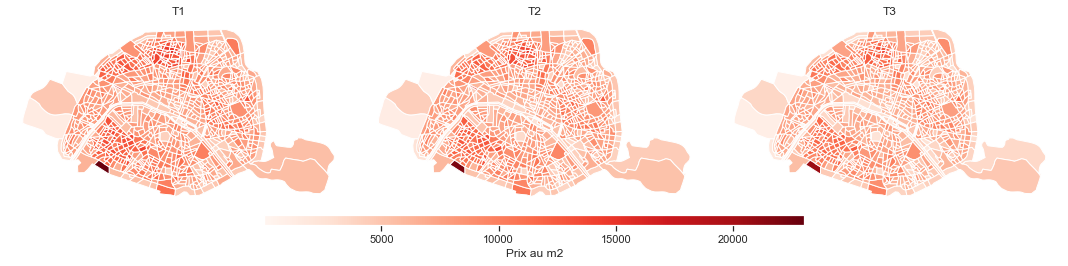

In [53]:
fig, axes = plt.subplots(1,3, figsize=(15, 6))

iris_plot=df_info_iris[df_info_iris["IRIS"].str.startswith("751")]

vmin=np.min(iris_plot[["pred_t1_30_hedo", "pred_t2_45_hedo", "pred_t3_65_hedo"]])
vmax=np.max(iris_plot[["pred_t1_30_hedo", "pred_t2_45_hedo", "pred_t3_65_hedo"]])
norm = colors.Normalize(vmin=vmin, vmax=vmax)

for i, col in enumerate(["pred_t1_30_hedo", "pred_t2_45_hedo", "pred_t3_65_hedo"]):
    iris_plot.plot(column=col, cmap="Reds", ax=axes[i], norm=norm)
    axes[i].set_title("T"+str(i+1))
    axes[i].axis("off")


cbar_ax = fig.add_axes([0.25, 0.3, 0.5, 0.025])  
sm = cm.ScalarMappable(cmap="Reds", norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Prix au m2")

plt.tight_layout(rect=[0, 0.12, 1, 1]) 
plt.show()